In [76]:
import time
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# import plotly.graph_objects as go

In [77]:
def distance(x1, x2):
    return np.linalg.norm(x1 - x2)


def euler_to_matrix(euler):
    yaw, pitch, roll = euler
    yaw, pitch, roll = math.radians(yaw), math.radians(pitch), math.radians(roll)

    sin_a, cos_a = math.sin(yaw), math.cos(yaw)
    sin_b, cos_b = math.sin(pitch), math.cos(pitch)
    sin_g, cos_g = math.sin(roll), math.cos(roll)

    R = np.array(
        [
            [
                cos_a * cos_b,
                cos_a * sin_b * sin_g - sin_a * cos_g,
                cos_a * sin_b * cos_g + sin_a * sin_g,
            ],
            [
                sin_a * cos_b,
                sin_a * sin_b * sin_g + cos_a * cos_g,
                sin_a * sin_b * cos_g - cos_a * sin_g,
            ],
            [-sin_b, cos_b * sin_g, cos_b * cos_g],
        ]
    )

    return R


def euler_to_dvector(angles):
    yaw, pitch, roll = angles
    sin_a, cos_a = math.sin(yaw), math.cos(yaw)
    sin_b, cos_b = math.sin(pitch), math.cos(pitch)
    sin_g, cos_g = math.sin(roll), math.cos(roll)

    direction_vector = np.array([cos_a * cos_b, sin_a * cos_b, -sin_b])

    return direction_vector

In [78]:
## TESTE

cm = np.array([0.5, 0.5, 0.2])
cf = np.array([0.5, 0.5, 0.0])

R = euler_to_matrix([30, 60, 0])
R_inv = R.T

cm_r = (R @ (cm - cf)) + cf
cf_r = (R @ (cf - cm)) + cm
# get reverse transformation [ given cm, need to find cf]

print(cm_r)
# print(distance(cm_r, cf), distance(cm, cf), distance(cm, cf_r))
# [ 0.16160254 -0.07990381  0.08660254]

[0.65       0.58660254 0.1       ]


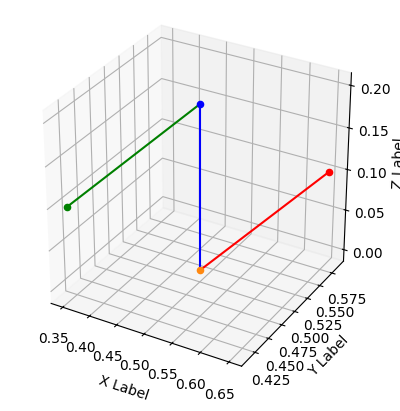

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")


# keep scale 1
ax.set_box_aspect([1, 1, 1])
ax.scatter(cm[0], cm[1], cm[2], c="b", marker="o")
ax.scatter(cf[0], cf[1], cf[2], c="#ff8810", marker="o")
ax.scatter(cf_r[0], cf_r[1], cf_r[2], c="g", marker="o")
ax.scatter(cm_r[0], cm_r[1], cm_r[2], c="r", marker="o")

# add line from origin to each point
ax.plot([cf[0], cm[0]], [cf[1], cm[1]], [cf[2], cm[2]], color="b")
ax.plot([cm[0], cf_r[0]], [cm[1], cf_r[1]], [cm[2], cf_r[2]], color="g")
ax.plot([cf[0], cm_r[0]], [cf[1], cm_r[1]], [cf[2], cm_r[2]], color="r")

ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")

plt.show()

In [294]:
class Environment:
    def __init__(self):
        self.g = 9.8

In [299]:
class Rocket:
    def __init__(
        self,
        environment,
        time=8,
        orientation=np.array([0.0, 0.0, 0.0]),
        force=11,
        mass=0.5,
        fuel_mass=0.2,
        motor_uptime=2,
    ):
        self.environment = environment
        self.com = np.array([0.0, 0.0, 0.0])
        self.position = np.array(
            [0.0, 0.0, 0.0 - 2]
        )  # distance from base to center of mass =0.2
        self.velocity = np.array([0.0, 0.0, 0.0])
        self.acceleration = np.array([0.0, 0.0, 0.0])
        self.orientation = orientation  # direction vector of the rocket
        self.angular_velocity = np.array([0.0, 0.0, 0.0])
        self.angular_acceleration = np.array([0.0, 0.0, 0.0])
        self.mass = mass
        self.thrust = orientation
        # self.thrust = euler_to_dvector(orientation)
        self.force = force
        self.moment = np.array([0.0, 0.0, 0.0])
        self.inertia = np.array([0.0, 0.0, 0.0])
        self.trajectory = []
        self.trajectory_cf = []
        self.update_delay = 0.01
        self.time = time
        self.motor_uptime = motor_uptime
        self.Ix = self.mass * 0.04
        self.fuel_mass = fuel_mass
        self.random_acceleration = np.array([0.0, 0.0, 0.0])
        self.random_moment = np.array([0.0, 0.0, 0.0])

    def run(self):
        # print(self.position, self.velocity, self.acceleration)
        self.trajectory.append(self.com.copy())
        self.trajectory_cf.append(self.position.copy())
        self.update_thrust()
        # time.sleep(self.update_delay)

    def plot_trajectory(self):
        trajectory = np.array(self.trajectory)
        trajectory_cf = np.array(self.trajectory_cf)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        ax.set_box_aspect([1, 1, 1])
        colors = np.linspace(0.1, 1, len(trajectory))
        colors_cf = np.linspace(0.1, 1, len(trajectory_cf))

        ax.scatter(
            trajectory[:, 0],
            trajectory[:, 1],
            trajectory[:, 2],
            c=colors,
            marker="o",
        )

        ax.scatter(
            trajectory_cf[:, 0],
            trajectory_cf[:, 1],
            trajectory_cf[:, 2],
            c="black",
            marker="o",
            s=0.1,
        )

        ax.set_xlabel("X Axis")
        ax.set_ylabel("Y Axis")
        ax.set_zlabel("Z Axis")

        plt.show()

    def plot_height(self):
        trajectory = np.array(self.trajectory)
        trajectory_cf = np.array(self.trajectory_cf)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        colors = np.linspace(0.1, 1, len(trajectory))
        colors_cf = np.linspace(0.1, 1, len(trajectory_cf))

        ax.scatter(
            np.linspace(0, self.time, len(trajectory)),
            trajectory[:, 2],
            c=colors,
            marker="o",
            s=0.1,
        )

        ax.scatter(
            np.linspace(0, self.time, len(trajectory_cf)),
            trajectory_cf[:, 2],
            c="black",
            marker="o",
            s=0.1,
        )

        ax.set_xlabel("Time")
        ax.set_ylabel("Height")

        plt.show()

    def plot_xy(self):
        trajectory = np.array(self.trajectory)
        trajectory_cf = np.array(self.trajectory_cf)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        colors = np.linspace(0.1, 1, len(trajectory))
        colors_cf = np.linspace(0.1, 1, len(trajectory_cf))

        ax.scatter(trajectory[:, 0], trajectory[:, 1], c=colors, marker="o", s=0.1)

        ax.scatter(
            trajectory_cf[:, 0], trajectory_cf[:, 1], c="black", marker="o", s=0.1
        )

        ax.set_xlabel("X")
        ax.set_ylabel("Y")

        plt.show()

    def update_thrust(self):
        delta = self.update_delay
        mass = self.mass + max(0, self.fuel_mass)
        self.fuel_mass -= (delta * self.fuel_mass) / self.motor_uptime
        # check the component of the thrust vector along orientation vector
        thrust_p = (
            np.dot(self.thrust, self.orientation)
            / np.dot(self.orientation, self.orientation)
        ) * self.orientation
        moment = self.thrust - thrust_p

        # self.acceleration = ((self.force + self.environment.g) * self.thrust) / self.mass
        self.acceleration = (
            (self.force * thrust_p) + (self.environment.g * np.array([0.0, 0.0, -1.0]))
        ) / mass
        # add random force to the rocket
        self.random_acceleration += np.random.uniform(-0.5, 0.5, 3)
        self.acceleration += self.random_acceleration

        self.velocity += self.acceleration * delta
        self.com += self.velocity * delta

        if self.com[2] < 0.2:
            self.com[2] = 0.2

        # update angular acceleration
        self.Ix = mass * 0.04
        self.random_moment += np.random.uniform(-0.5, 0.5, 3)
        moment += self.random_moment
        self.angular_acceleration = moment / self.Ix
        self.angular_velocity += self.angular_acceleration * delta
        theta = self.angular_velocity * delta

        # update orientation
        R = euler_to_matrix(theta)
        self.orientation = R @ self.orientation

        # update position
        self.position = self.com - self.orientation * 0.2

In [296]:
def simple_controller(rocket):
    # It should only use rocket's orientation and acceleration
    flight_time = rocket.time
    counter = flight_time
    delta = rocket.update_delay
    while counter > 0:
        if counter < flight_time - rocket.motor_uptime:
            rocket.force = 0
        else:
            rocket.thrust += np.array(
                [0.0001, 0.0001, 0.0]
            )  # controling the direction of the thrust
        counter -= delta
        rocket.run()

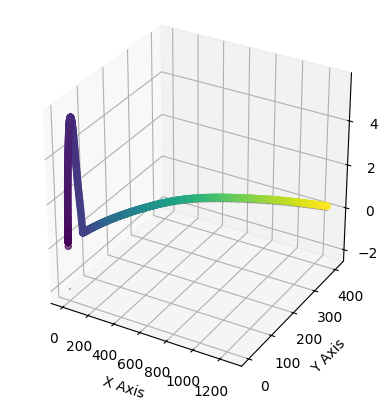

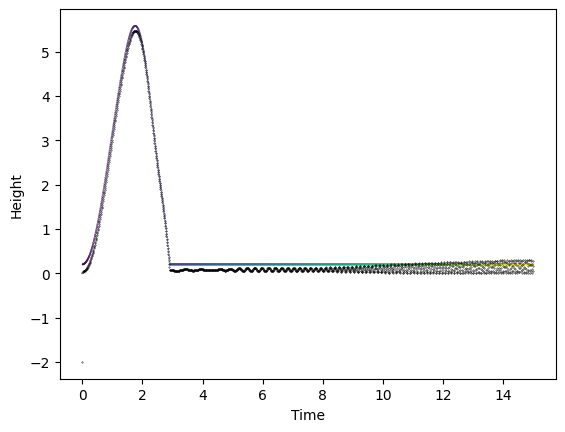

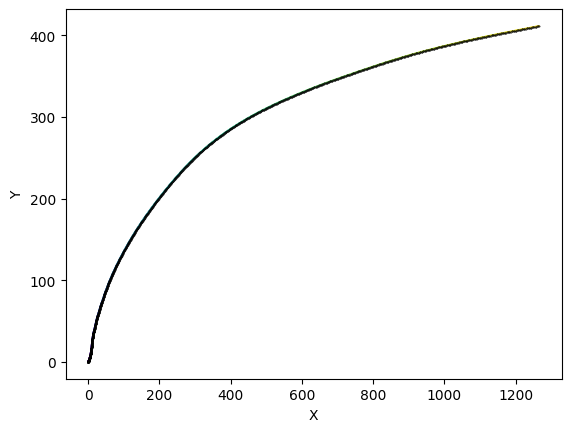

In [330]:
e = Environment()
orientation = np.array([0.5, 0.5, 1.0])
# normalize orientation
orientation = orientation / np.linalg.norm(orientation)

r = Rocket(e, 15, orientation, 18, 0.5, 0.2, 8)

# R = euler_to_matrix(orientation)
# position = (R @ np.array([0.0,0.0,-0.2])) + r.com
# print(position, r.com)
# print(distance(position, r.com))

simple_controller(r)
r.plot_trajectory()
r.plot_height()
r.plot_xy()

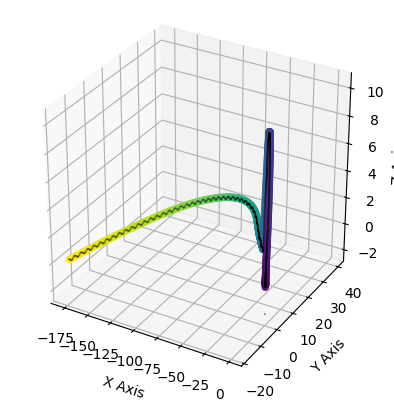

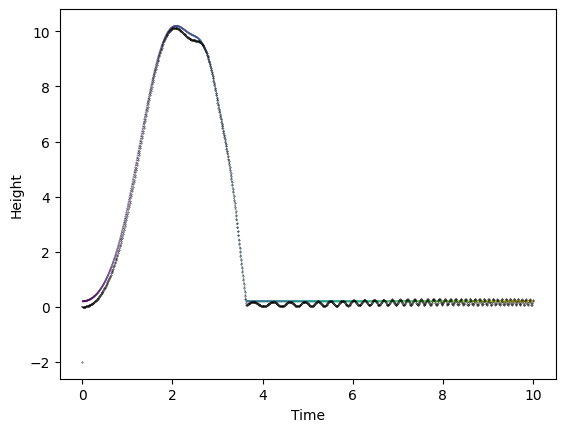

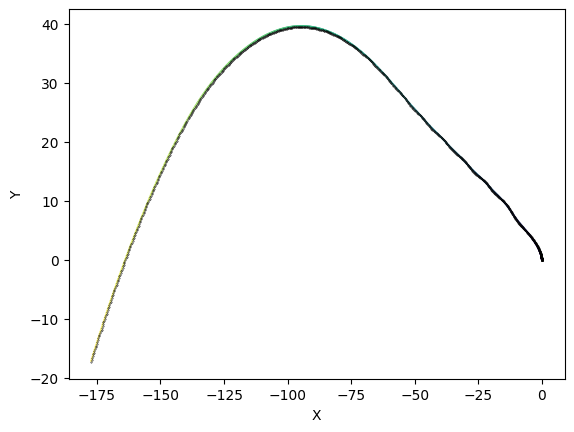

In [331]:
e = Environment()
orientation = np.array([0.0, 0.01, 1.0])
# normalize orientation
orientation = orientation / np.linalg.norm(orientation)

r = Rocket( e, 10, orientation, 12,  0.5, 0.1, 5)

# R = euler_to_matrix(orientation)
# position = (R @ np.array([0.0,0.0,-0.2])) + r.com
# print(position, r.com)
# print(distance(position, r.com))

simple_controller(r)
r.plot_trajectory()
r.plot_height()
r.plot_xy()